In [ ]:
import sys 
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import yaml
import argparse
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import logging
import time
from typing import Dict, Any
import matplotlib.pyplot as plt

from model.model_utils import get_model_from_configs, create_model_with_pretrained
from training.training_loops import get_training_loop_by_model_name
from training.visualize import get_full_image_and_prediction, compute_metrics, plot_intensity_histograms, display_inference_results
from sarpyx.utils.losses import get_loss_function
from training_script import load_config
from training_script import create_dataloaders
import matplotlib.pyplot as plt
import numpy as np

def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler("visualization.log"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

In [ ]:
args = argparse.Namespace(
    config="training_configs/s4_ssm_student_new.yaml", 
    pretrained_path=os.path.join(os.getcwd(), '..', 'results/progressive_layer_distillation/checkpoints/best.ckpt'), #'results', 'enhanced_distillation','checkpoints', 'last-v3.ckpt'),
    # config="training_configs/s4_ssm_complex_sweep.yaml", #"training_configs/s4_ssm_student.yaml",
    # pretrained_path=os.path.join(os.getcwd(), '..', 'results/s4_ssm_smaller_cols/last.ckpt'), #'results', 'enhanced_distillation','checkpoints', 'last-v3.ckpt'),
    # config="training_configs/s4_ssm_student.yaml", 
    # pretrained_path=os.path.join(os.getcwd(), '..', 'results', 'enhanced_distillation','checkpoints', 'last-v3.ckpt'), 
    device="cuda", 
    batch_size=16,
    save_dir="./visualizations",
    mode="parallel",
    learning_rate=1e-4, 
    num_epochs=50
)

# # Setup logging
logger = setup_logging()
#logger.info(f"Starting visualization with config: {args.config}")

# Load configuration
config = load_config(Path(args.config), args)

# Extract configurations
dataloader_cfg = config['dataloader']
training_cfg = config.get('training', {})

# Override save directory
save_dir = args.save_dir or training_cfg.get('save_dir', './visualizations')

# Create test dataloader
dataloader_cfg['patch_size'] = [5000, 1]
dataloader_cfg['stride'] = [4000, 1]
logger.info("Configuration Summary:")
logger.info(f"  Data directory: {dataloader_cfg.get('data_dir', 'Not specified')}")
logger.info(f"  Level from: {dataloader_cfg.get('level_from', 'rc')}")
logger.info(f"  Level to: {dataloader_cfg.get('level_to', 'az')}")
logger.info(f"  Patch size: {dataloader_cfg.get('patch_size', [1000, 1])}")
logger.info(f"  Batch size: {dataloader_cfg.get('test', {}).get('batch_size', 'Not specified')}")
logger.info(f"  Save directory: {save_dir}")
logger.info("Creating test dataloader...")
try:
    _, _, _, inference_loader = create_dataloaders(dataloader_cfg)
    logger.info(f"Created test dataloader with {len(inference_loader)} batches")
    logger.info(f"Dataset contains {len(inference_loader.dataset)} samples")
except Exception as e:
    logger.error(f"Failed to create test dataloader: {str(e)}")
    raise

try:
    model = create_model_with_pretrained(config['model'], pretrained_path=args.pretrained_path, device=args.device, start_key='model.')
except Exception as e:
    logger.error(f"Failed to load model: {str(e)}")
    raise

# Visualize samples
logger.info("Starting sample visualization...")
model_name = config['model']['name']
print(f"Using model: {model}")
inference_fn = get_training_loop_by_model_name(model_name, train_loader=inference_loader, val_loader=inference_loader, test_loader=inference_loader, model=model, save_dir=save_dir, mode=args.mode, loss_fn_name="mse", input_dim=model.input_dim)[0].forward
gts = []
preds = []
inputs = []
orig_gts = []
orig_preds = []
for i in range(5):
    gt, pred, input, orig_gt, orig_pred = get_full_image_and_prediction(
        dataloader=inference_loader,
        show_window=((1000, 1000), (10000, 5000)),
        zfile=i,
        inference_fn=inference_fn,
        return_input=True, 
        return_original=True,
        device="cuda", 
        vminmax='auto' #(2000, 6000)
    )
    gts.append(gt)
    preds.append(pred)
    inputs.append(input)
    orig_gts.append(orig_gt)
    orig_preds.append(orig_pred)
    # print(compute_metrics(gt, pred))
    # display_inference_results(
    #     input_data=input,
    #     gt_data=gt,
    #     pred_data=pred,
    #     figsize=(20, 6),
    #     vminmax="auto",  # Adjust this range based on your data, 
    #     show=True, 
    #     save=False
    # )
    # plot_intensity_histograms(orig_gt[..., 0], orig_pred, gt, pred, figsize=(20, 12), bins=100)
    # logger.info("Visualization completed successfully!")
    # logger.info(f"Check the visualizations in: {save_dir}")
    

2025-10-14 14:16:04,081 - INFO - Configuration Summary:
2025-10-14 14:16:04,082 - INFO -   Data directory: /Data/sar_focusing
2025-10-14 14:16:04,082 - INFO -   Level from: rc
2025-10-14 14:16:04,083 - INFO -   Level to: az
2025-10-14 14:16:04,084 - INFO -   Patch size: [5000, 1]
2025-10-14 14:16:04,084 - INFO -   Batch size: 32
2025-10-14 14:16:04,085 - INFO -   Save directory: ./visualizations
2025-10-14 14:16:04,085 - INFO - Creating test dataloader...


Total files found in remote repository: 967
Total files found in remote repository: 967
Total files found in remote repository: 967
Total files found in remote repository: 967


2025-10-14 14:16:59,903 - INFO - Created test dataloader with 15625 batches
2025-10-14 14:16:59,903 - INFO - Dataset contains 500000 samples
2025-10-14 14:17:00,139 - INFO - Starting sample visualization...
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
2025-10-14 14:17:00,143 - INFO - 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
2025-10-14 14:17:00,161 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-10-14 14:17:00,162 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-10-14 14:17:00,163 - INFO - HPU available: False, using: 0 

Using model: sarSSMFinal(
  (ssm): ModuleList(
    (0-3): 4 x S4D(
      (kernel): S4DKernel(
        (kernel): SSKernelDiag()
      )
      (activation): LeakyReLU(negative_slope=0.125)
      (dropout): Identity()
      (output_linear): Linear(in_features=2, out_features=2, bias=True)
    )
  )
  (fc1): Linear(in_features=4, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=2, bias=True)
)
BASE SAVE DIR: ./visualizations
Total inference time for 0 batches: 2.66 seconds
Only one batch processed, total time: 2.66 seconds

=== INFERENCE MEMORY STATISTICS ===
Initial memory: RAM: 3388.5MB | GPU Allocated: 0.1MB | GPU Reserved: 2.0MB
Peak memory: RAM: 7169.6MB | GPU Allocated: 9.4MB | GPU Reserved: 42.0MB
Average RAM increase per inference: -0.3MB
Maximum RAM increase per inference: 2.4MB
Average GPU allocated increase per inference: 1.3MB
Maximum GPU allocated increase per inference: 9.3MB
Average GPU reserved increase per inference: 0.2MB
Maximum GPU reserved increas

{'mse': 15213063.0, 'rmse': np.float64(3900.3926725395227), 'psnr_db': 16.800032071599333, 'ssim': 0.04477600165786685, 'amplitude_correlation': 0.14031915272349682, 'phase_mae_rad': 0.0, 'phase_rmse_rad': 0.0, 'phase_mae_deg': np.float64(0.0), 'phase_rmse_deg': np.float64(0.0), 'complex_coherence': 0.7817511988193394, 'phase_coherence': 0.9998888969421387, 'enl_reference': 0.6913689374923706, 'enl_predicted': 0.6858925223350525, 'enl_ratio': 0.9920788816790332, 'resolution_gain': 0.07692307692307693}


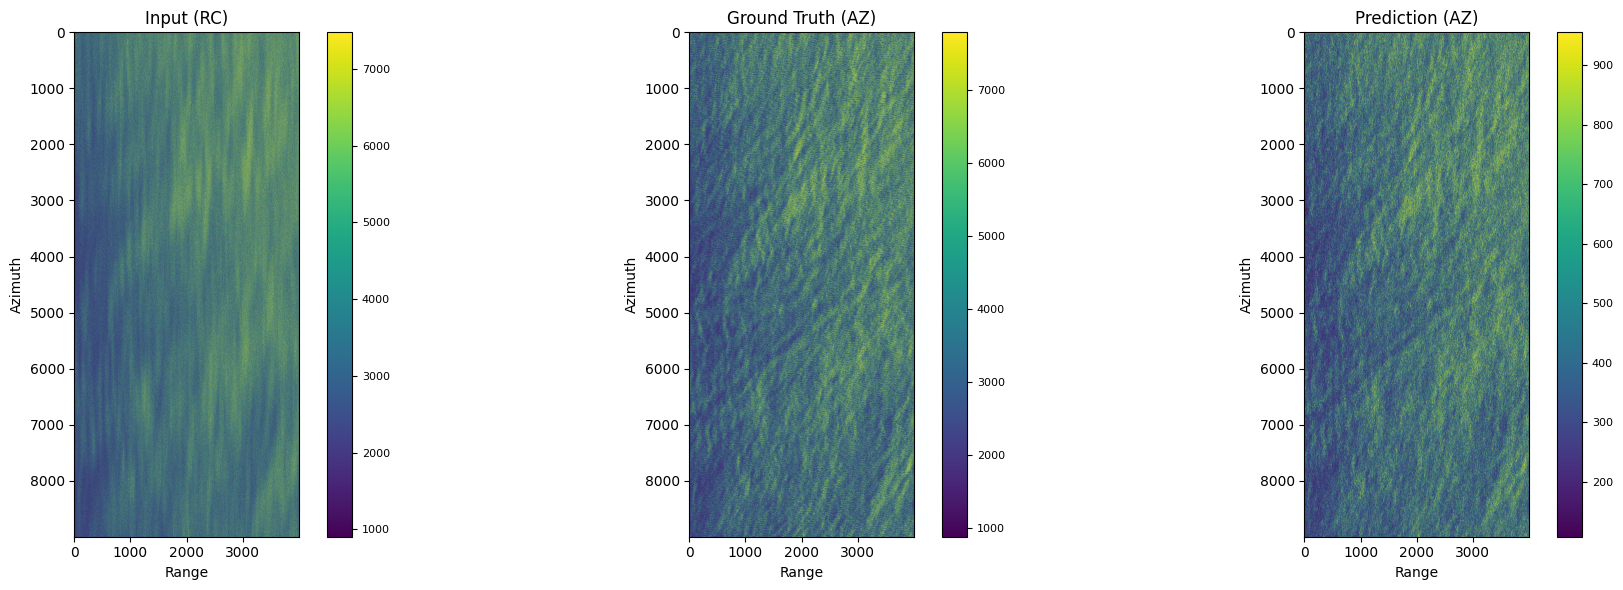

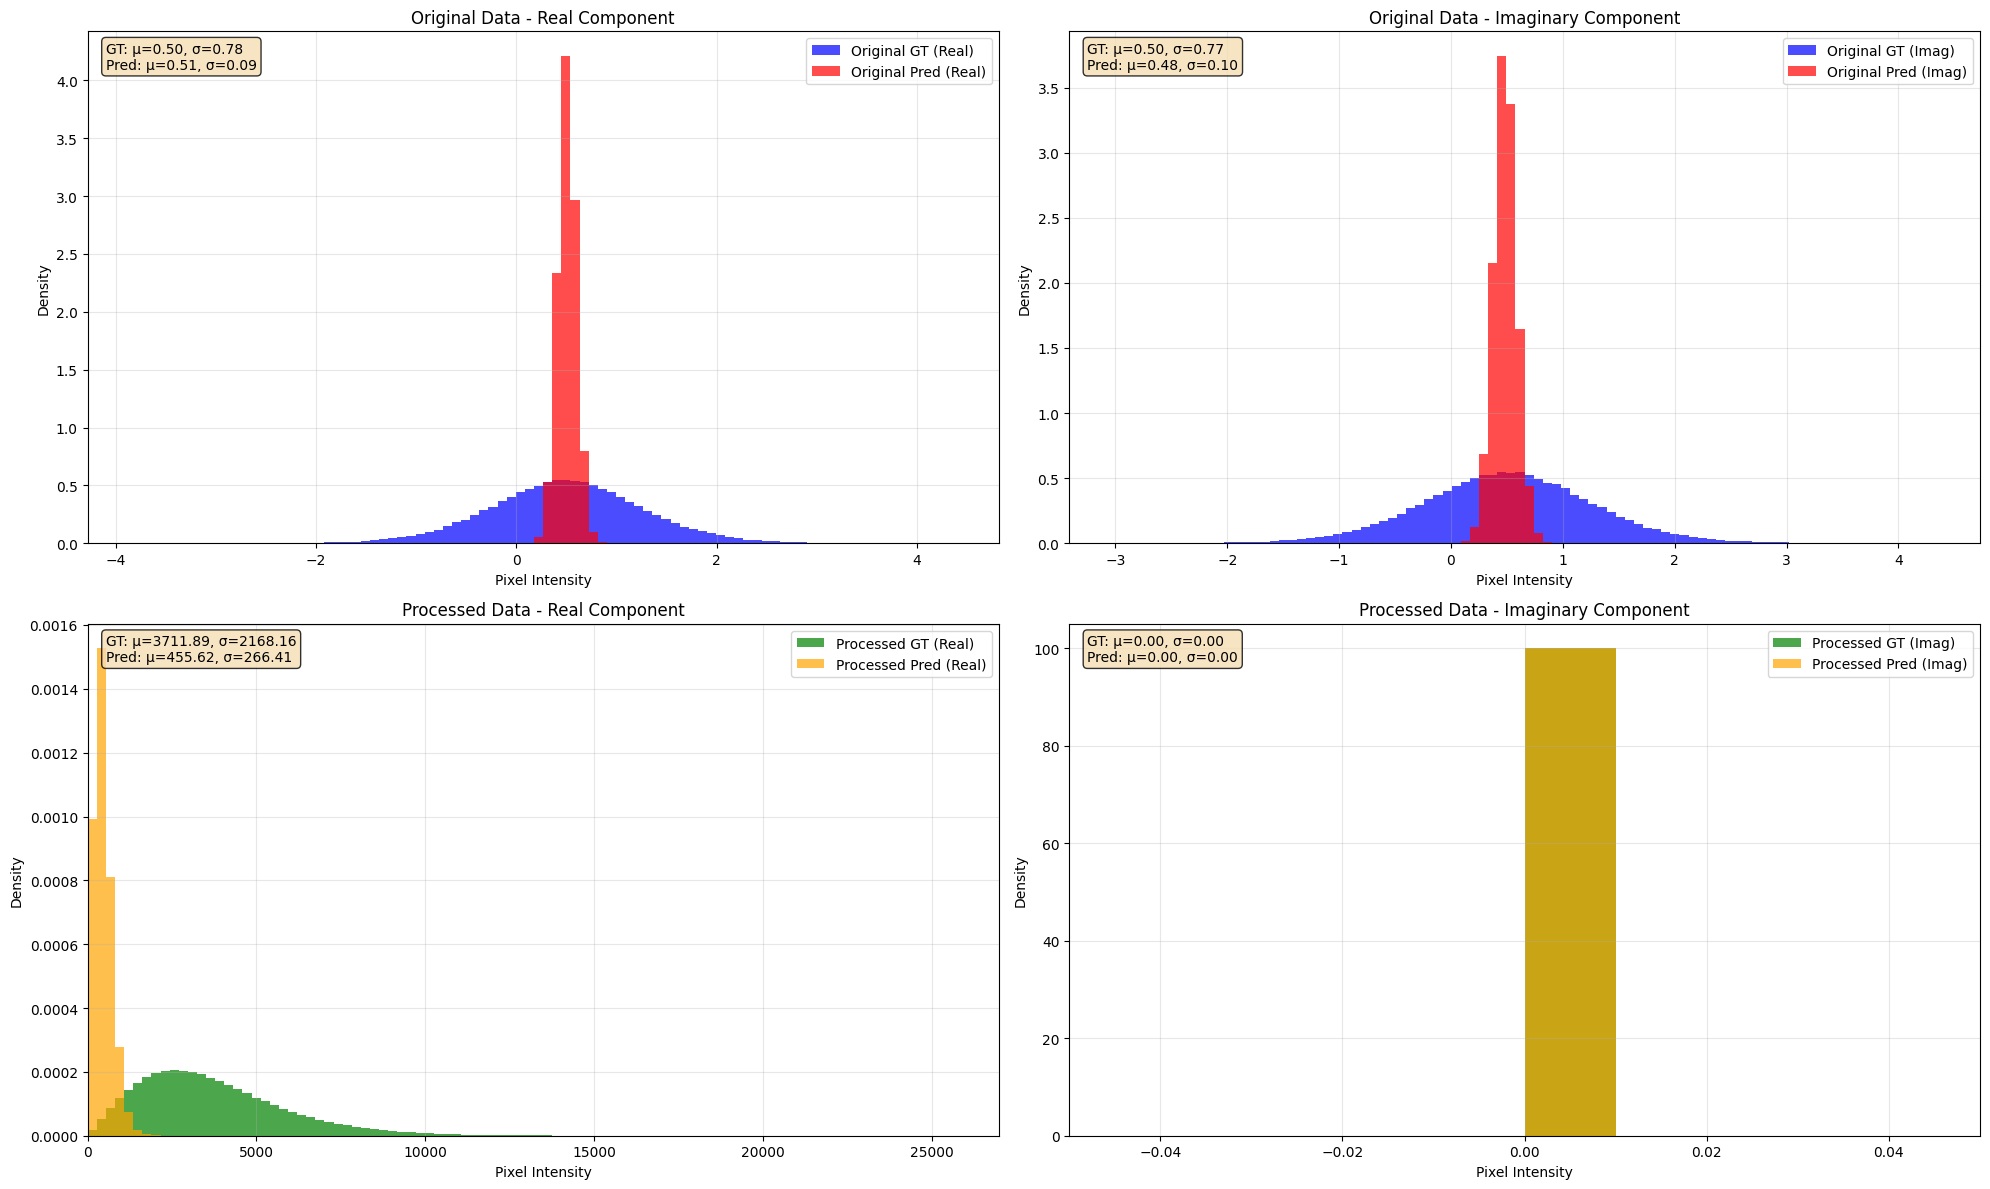


DETAILED STATISTICS

Original Data:
------------------------------

Real Component:
  GT    - Mean:   0.4997, Std:   0.7760, Min:  -4.2795, Max:   4.8154
  Pred  - Mean:   0.5061, Std:   0.0909, Min:   0.1020, Max:   0.9159
  Diff  - Mean:  -0.0064, Std:   0.7648

Imaginary Component:
  GT    - Mean:   0.5010, Std:   0.7729, Min:  -3.4130, Max:   4.7292
  Pred  - Mean:   0.4834, Std:   0.1020, Min:   0.0442, Max:   0.9709
  Diff  - Mean:   0.0175, Std:   0.7581

Processed Data:
------------------------------

Real Component:
  GT    - Mean: 3711.8867, Std: 2168.1597, Min:   0.0000, Max: 26984.2246
  Pred  - Mean: 455.6200, Std: 266.4098, Min:   0.0000, Max: 3186.5007
  Diff  - Mean: 3256.2668, Std: 2147.0420

Imaginary Component:
  GT    - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000
  Pred  - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000


2025-10-14 14:37:24,723 - INFO - Visualization completed successfully!
2025-10-14 14:37:24,724 - INFO - Check the visualizations in: ./visualizations


  Diff  - Mean:   0.0000, Std:   0.0000
{'mse': 17822078.0, 'rmse': np.float64(4221.620305048762), 'psnr_db': 25.3342805248285, 'ssim': 0.1564995918470827, 'amplitude_correlation': 0.09841996191527759, 'phase_mae_rad': 0.0, 'phase_rmse_rad': 0.0, 'phase_mae_deg': np.float64(0.0), 'phase_rmse_deg': np.float64(0.0), 'complex_coherence': 0.7846812908526832, 'phase_coherence': 0.9998888969421387, 'enl_reference': 0.75681471824646, 'enl_predicted': 0.7669386267662048, 'enl_ratio': 1.013376997401956, 'resolution_gain': 0.07692307692307693}


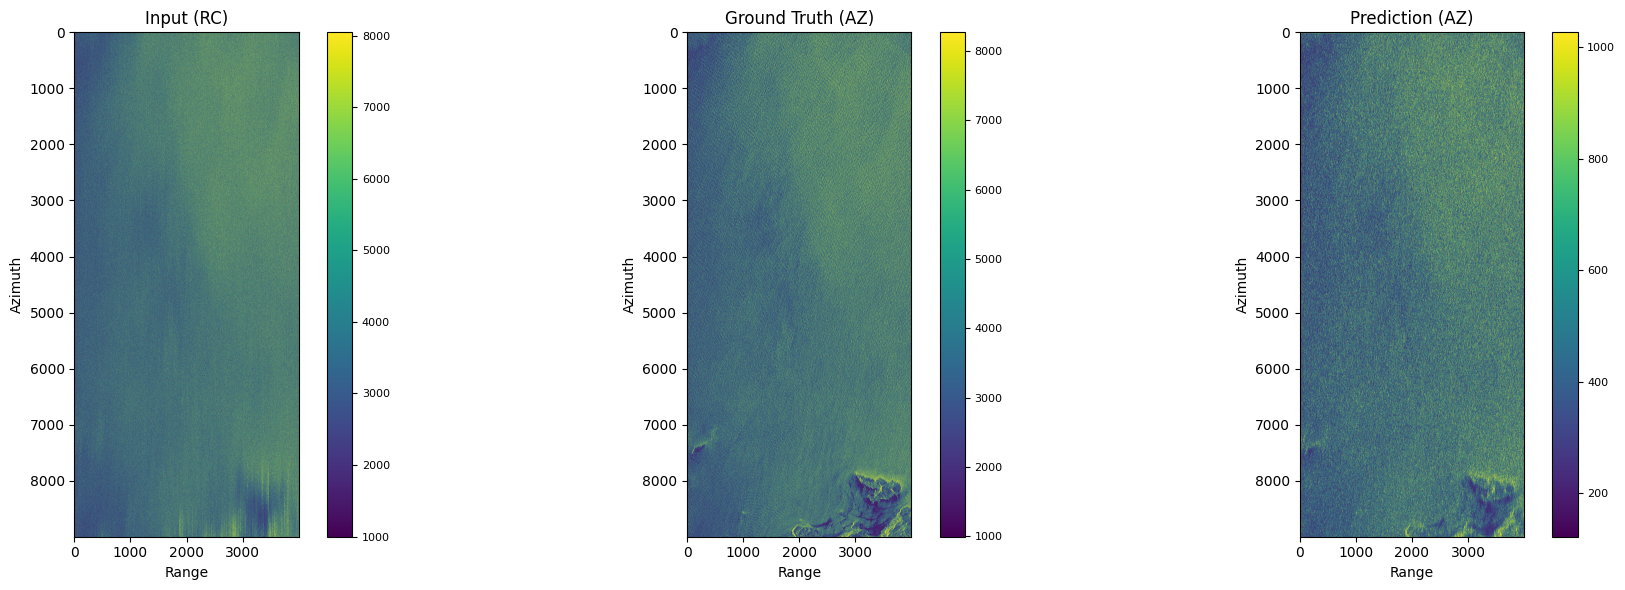

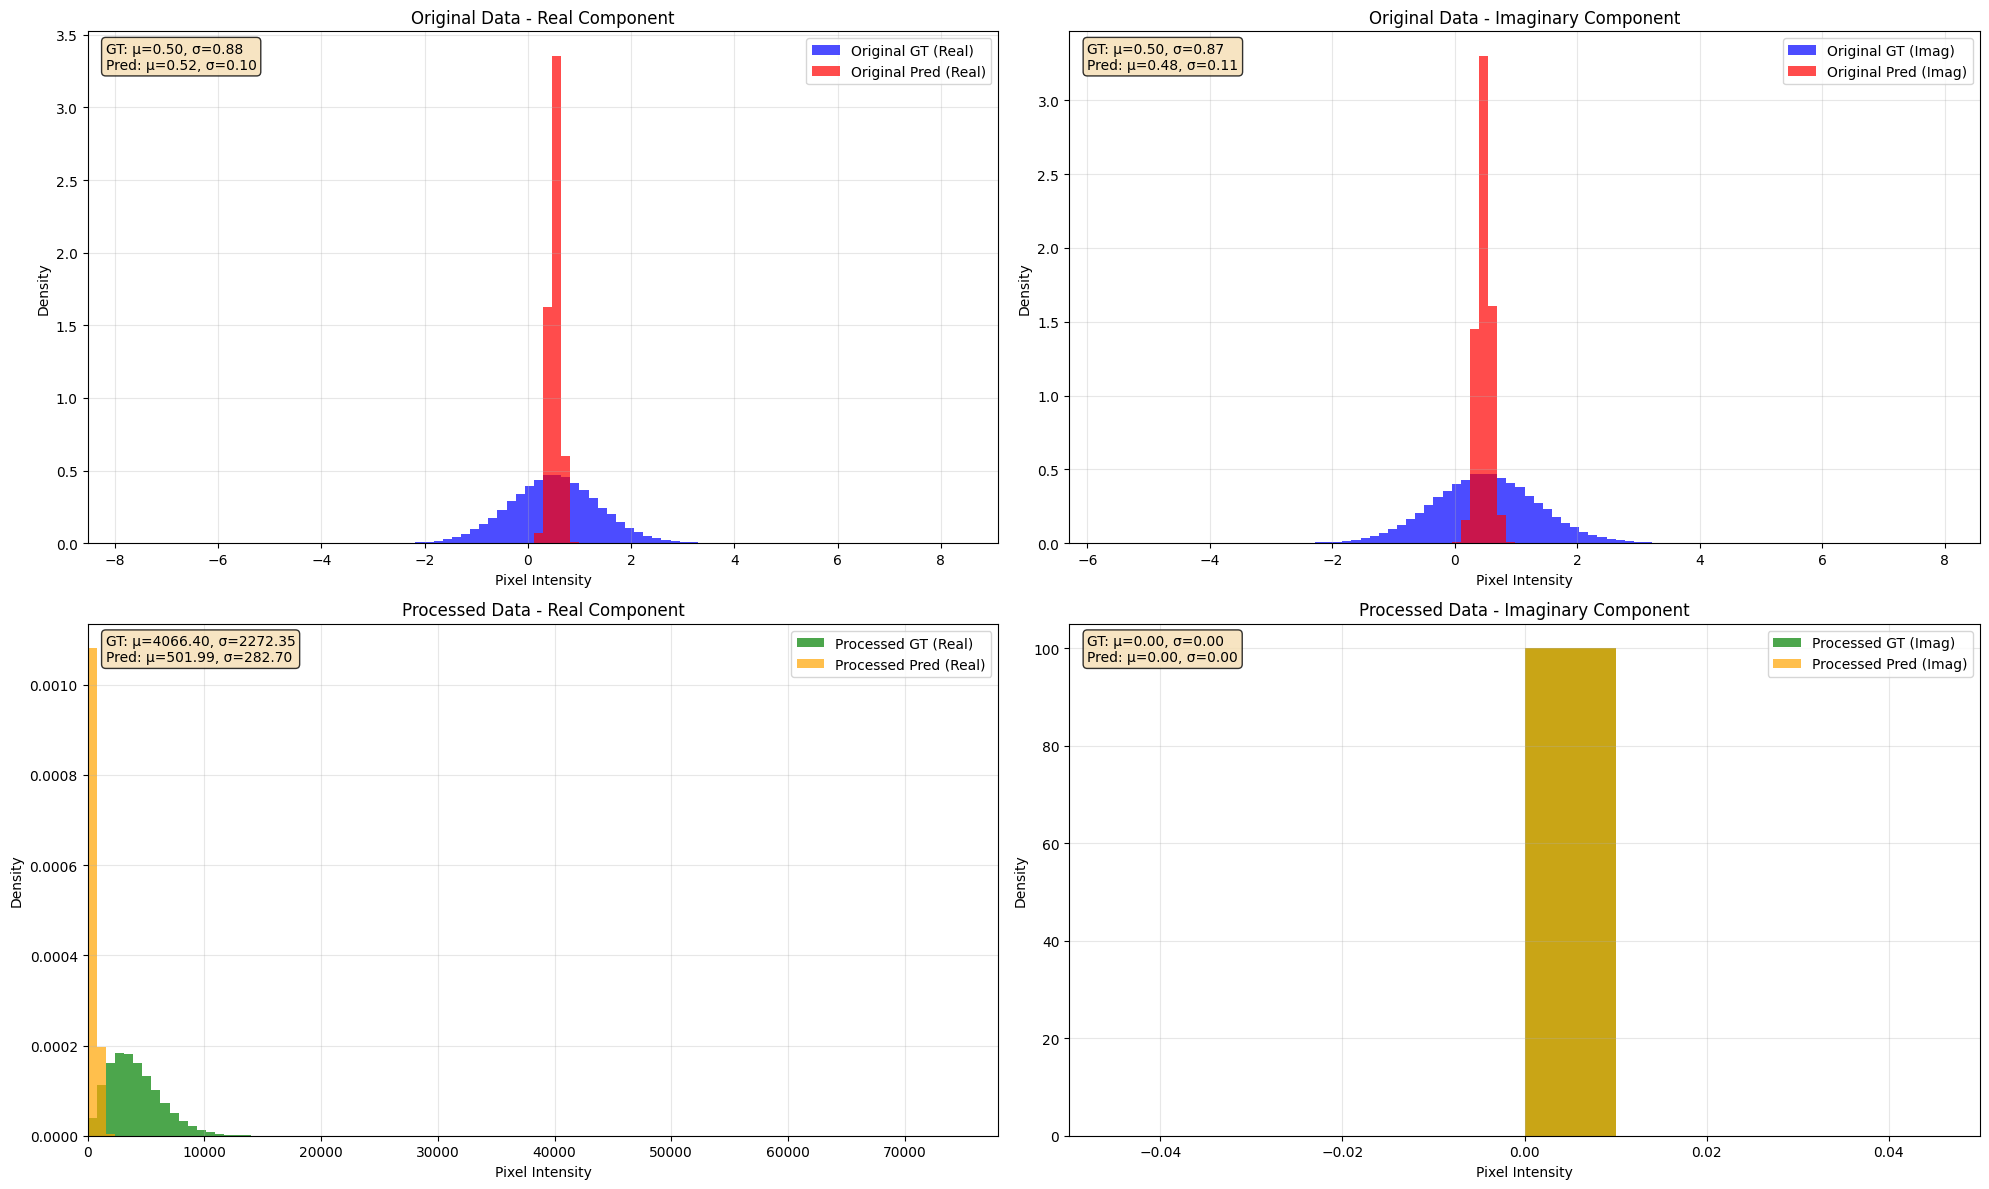


DETAILED STATISTICS

Original Data:
------------------------------

Real Component:
  GT    - Mean:   0.5013, Std:   0.8779, Min:  -8.5317, Max:   9.1166
  Pred  - Mean:   0.5210, Std:   0.1012, Min:  -0.0290, Max:   0.9998
  Diff  - Mean:  -0.0197, Std:   0.8654

Imaginary Component:
  GT    - Mean:   0.5008, Std:   0.8699, Min:  -6.2971, Max:   8.5770
  Pred  - Mean:   0.4754, Std:   0.1147, Min:  -0.0068, Max:   0.9546
  Diff  - Mean:   0.0254, Std:   0.8535

Processed Data:
------------------------------

Real Component:
  GT    - Mean: 4066.3960, Std: 2272.3538, Min:   0.0000, Max: 78017.7109
  Pred  - Mean: 501.9866, Std: 282.7023, Min:   0.0000, Max: 4067.9370
  Diff  - Mean: 3564.4097, Std: 2262.0923

Imaginary Component:
  GT    - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000
  Pred  - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000


2025-10-14 14:38:05,654 - INFO - Visualization completed successfully!
2025-10-14 14:38:05,655 - INFO - Check the visualizations in: ./visualizations


  Diff  - Mean:   0.0000, Std:   0.0000
{'mse': 17809262.0, 'rmse': np.float64(4220.102131465541), 'psnr_db': 45.275059232462446, 'ssim': 0.8359176465011869, 'amplitude_correlation': 0.14800400569009287, 'phase_mae_rad': 0.0, 'phase_rmse_rad': 0.0, 'phase_mae_deg': np.float64(0.0), 'phase_rmse_deg': np.float64(0.0), 'complex_coherence': 0.7708121541120073, 'phase_coherence': 0.9998888969421387, 'enl_reference': 0.012723688036203384, 'enl_predicted': 0.4112186133861542, 'enl_ratio': 32.3191367326904, 'resolution_gain': 0.07692307692307693}


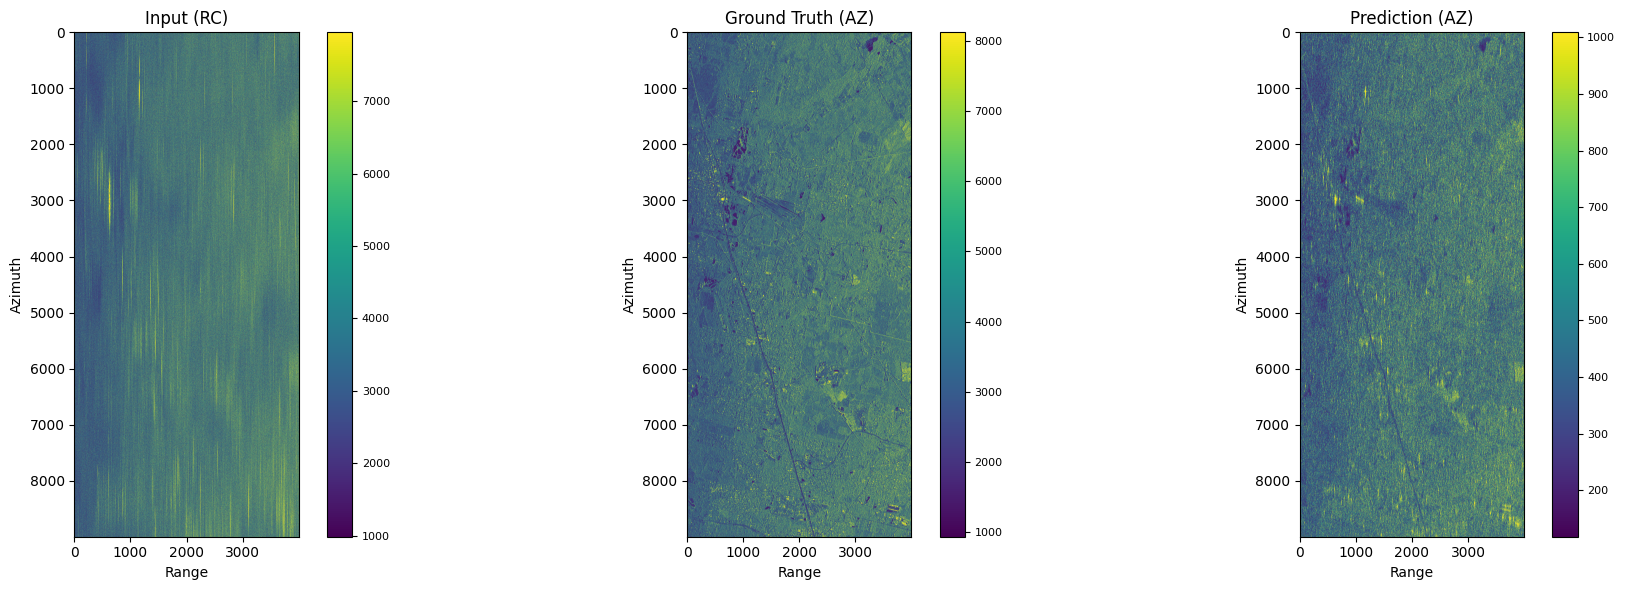

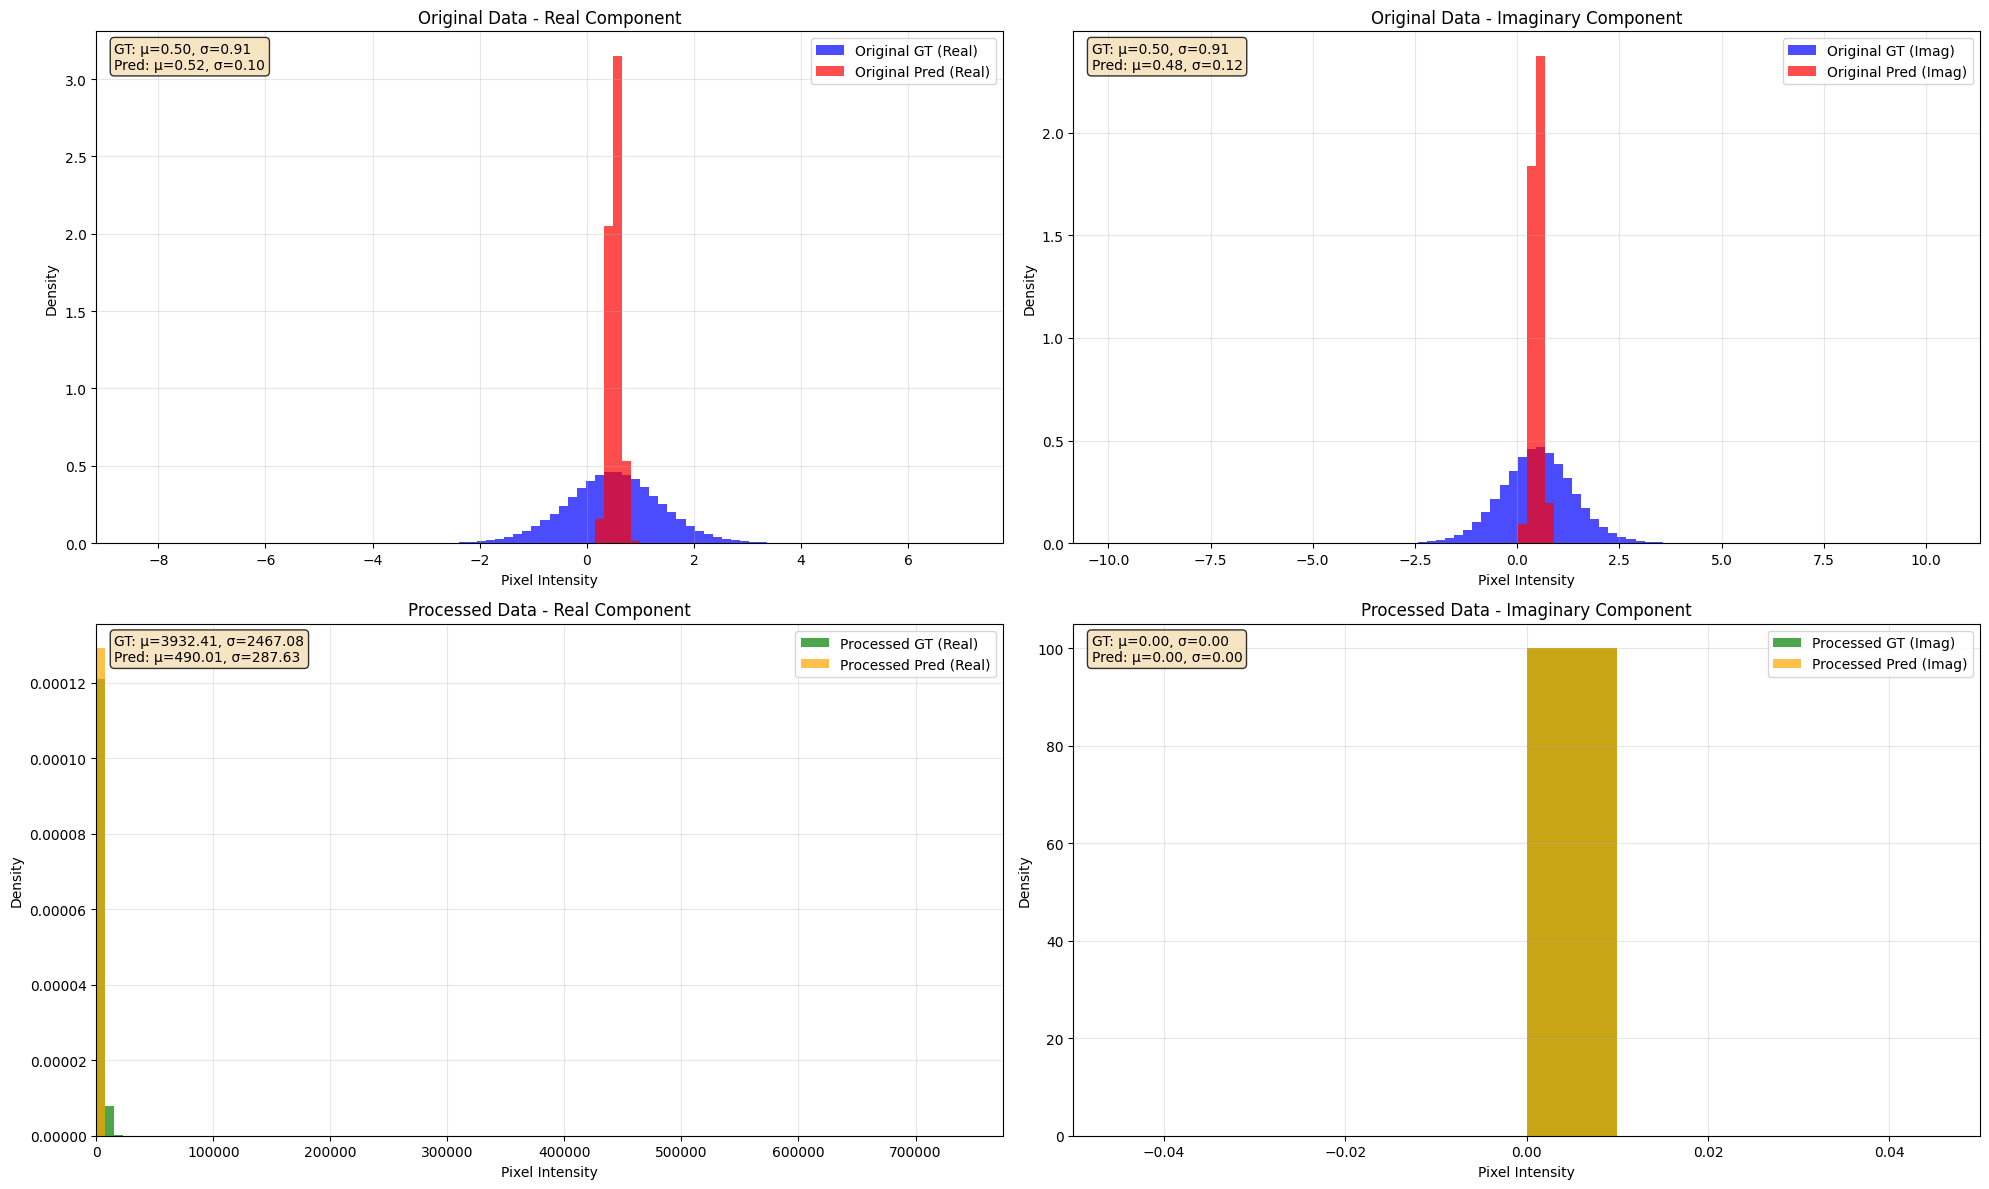


DETAILED STATISTICS

Original Data:
------------------------------

Real Component:
  GT    - Mean:   0.4999, Std:   0.9129, Min:  -9.1591, Max:   7.7651
  Pred  - Mean:   0.5205, Std:   0.1043, Min:   0.0132, Max:   1.0191
  Diff  - Mean:  -0.0207, Std:   0.9002

Imaginary Component:
  GT    - Mean:   0.5003, Std:   0.9090, Min: -10.8516, Max:  11.3185
  Pred  - Mean:   0.4758, Std:   0.1189, Min:  -0.0823, Max:   1.0471
  Diff  - Mean:   0.0246, Std:   0.8915

Processed Data:
------------------------------

Real Component:
  GT    - Mean: 3932.4067, Std: 2467.0769, Min:   0.0000, Max: 774597.1875
  Pred  - Mean: 490.0075, Std: 287.6297, Min:   0.0000, Max: 17812.2266
  Diff  - Mean: 3442.3989, Std: 2441.1372

Imaginary Component:
  GT    - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000
  Pred  - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000


2025-10-14 14:38:45,525 - INFO - Visualization completed successfully!
2025-10-14 14:38:45,525 - INFO - Check the visualizations in: ./visualizations


  Diff  - Mean:   0.0000, Std:   0.0000
{'mse': 22433030.0, 'rmse': np.float64(4736.351971718318), 'psnr_db': 27.611483046755115, 'ssim': 0.21867971043980075, 'amplitude_correlation': 0.31431085437301626, 'phase_mae_rad': 0.0, 'phase_rmse_rad': 0.0, 'phase_mae_deg': np.float64(0.0), 'phase_rmse_deg': np.float64(0.0), 'complex_coherence': 0.7734801560062549, 'phase_coherence': 0.9998888969421387, 'enl_reference': 0.18431195616722107, 'enl_predicted': 0.3381425142288208, 'enl_ratio': 1.8346206142049384, 'resolution_gain': 0.058823529411764705}


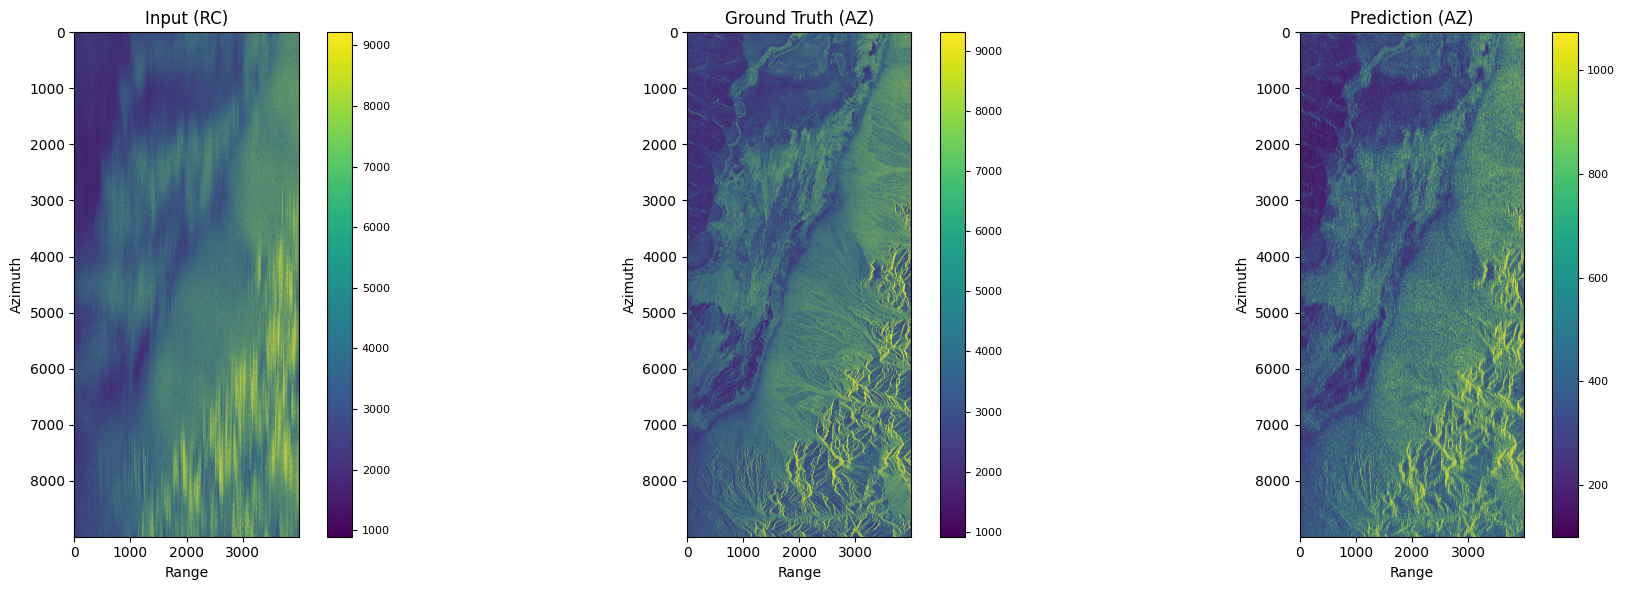

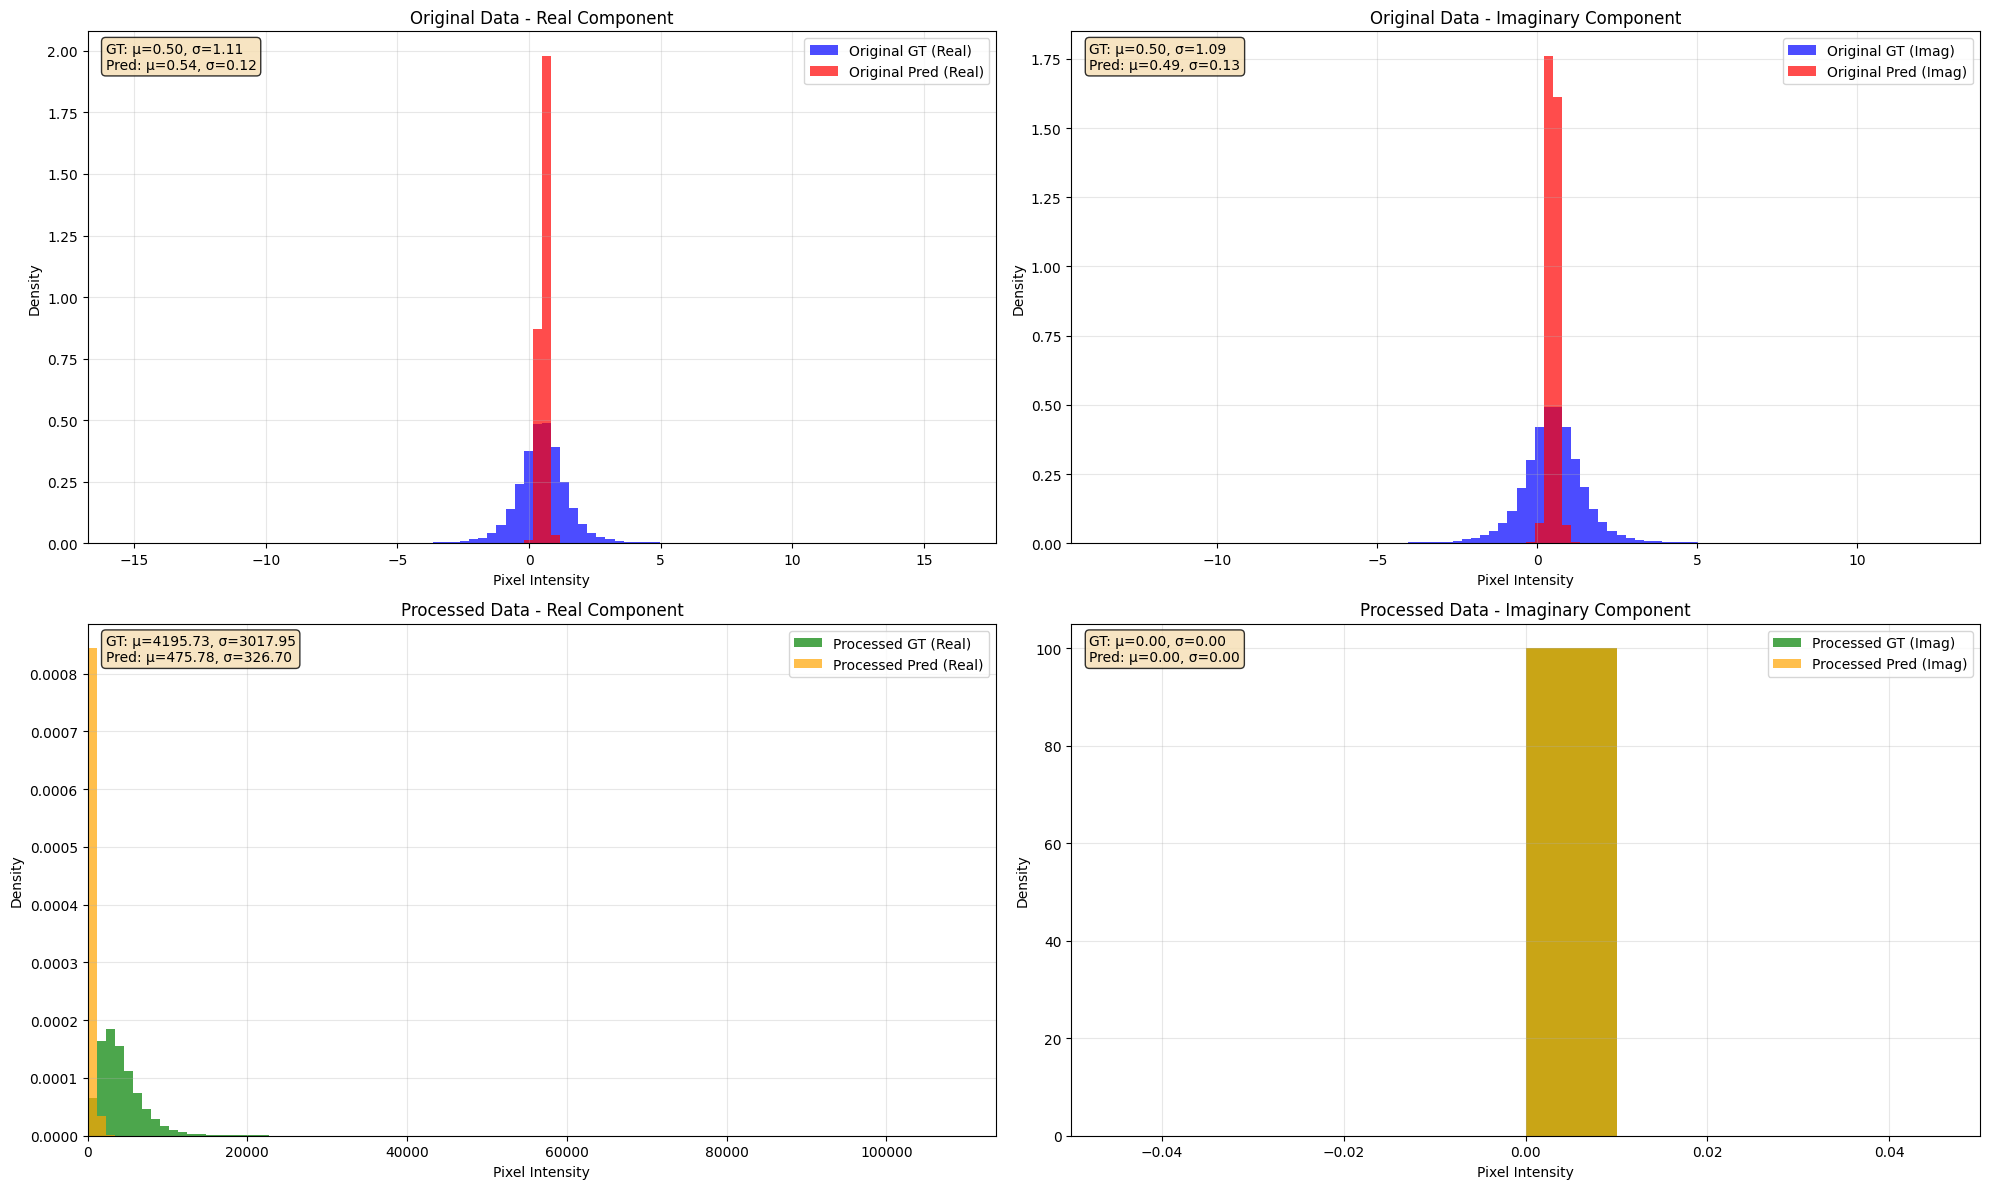


DETAILED STATISTICS

Original Data:
------------------------------

Real Component:
  GT    - Mean:   0.5001, Std:   1.1094, Min: -16.7711, Max:  17.7439
  Pred  - Mean:   0.5368, Std:   0.1158, Min:  -0.3028, Max:   1.1944
  Diff  - Mean:  -0.0367, Std:   1.1169

Imaginary Component:
  GT    - Mean:   0.5007, Std:   1.0918, Min: -14.5703, Max:  13.8529
  Pred  - Mean:   0.4880, Std:   0.1323, Min:  -0.3601, Max:   1.3973
  Diff  - Mean:   0.0127, Std:   1.0991

Processed Data:
------------------------------

Real Component:
  GT    - Mean: 4195.7305, Std: 3017.9529, Min:   0.0000, Max: 113767.4766
  Pred  - Mean: 475.7769, Std: 326.6990, Min:   0.0000, Max: 6758.9604
  Diff  - Mean: 3719.9539, Std: 2931.7185

Imaginary Component:
  GT    - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000
  Pred  - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000


2025-10-14 14:39:24,985 - INFO - Visualization completed successfully!
2025-10-14 14:39:24,986 - INFO - Check the visualizations in: ./visualizations


  Diff  - Mean:   0.0000, Std:   0.0000
{'mse': 20762666.0, 'rmse': np.float64(4556.606851594725), 'psnr_db': 27.824733008300576, 'ssim': 0.22242717589559358, 'amplitude_correlation': 0.3141807607483085, 'phase_mae_rad': 0.0, 'phase_rmse_rad': 0.0, 'phase_mae_deg': np.float64(0.0), 'phase_rmse_deg': np.float64(0.0), 'complex_coherence': 0.774035424777662, 'phase_coherence': 0.9998888969421387, 'enl_reference': 0.1806684136390686, 'enl_predicted': 0.3291391134262085, 'enl_ratio': 1.8217855949283317, 'resolution_gain': 0.058823529411764705}


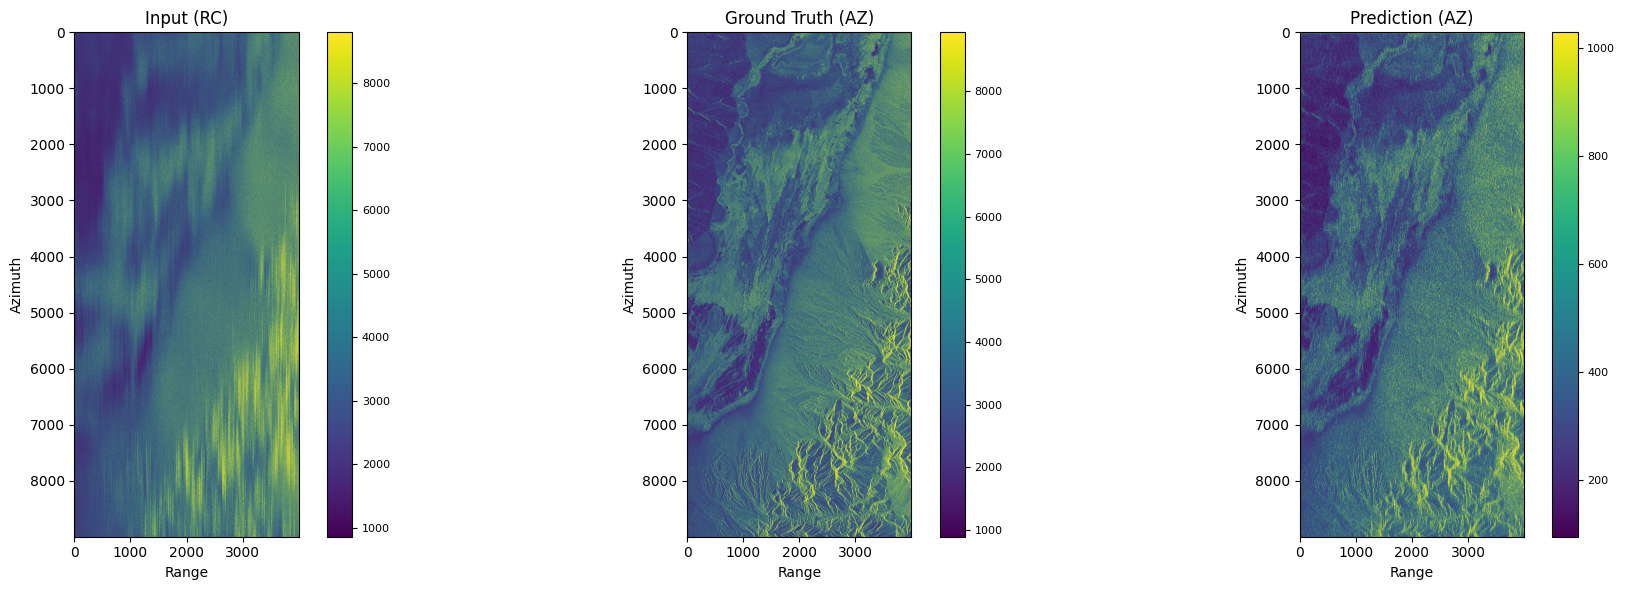

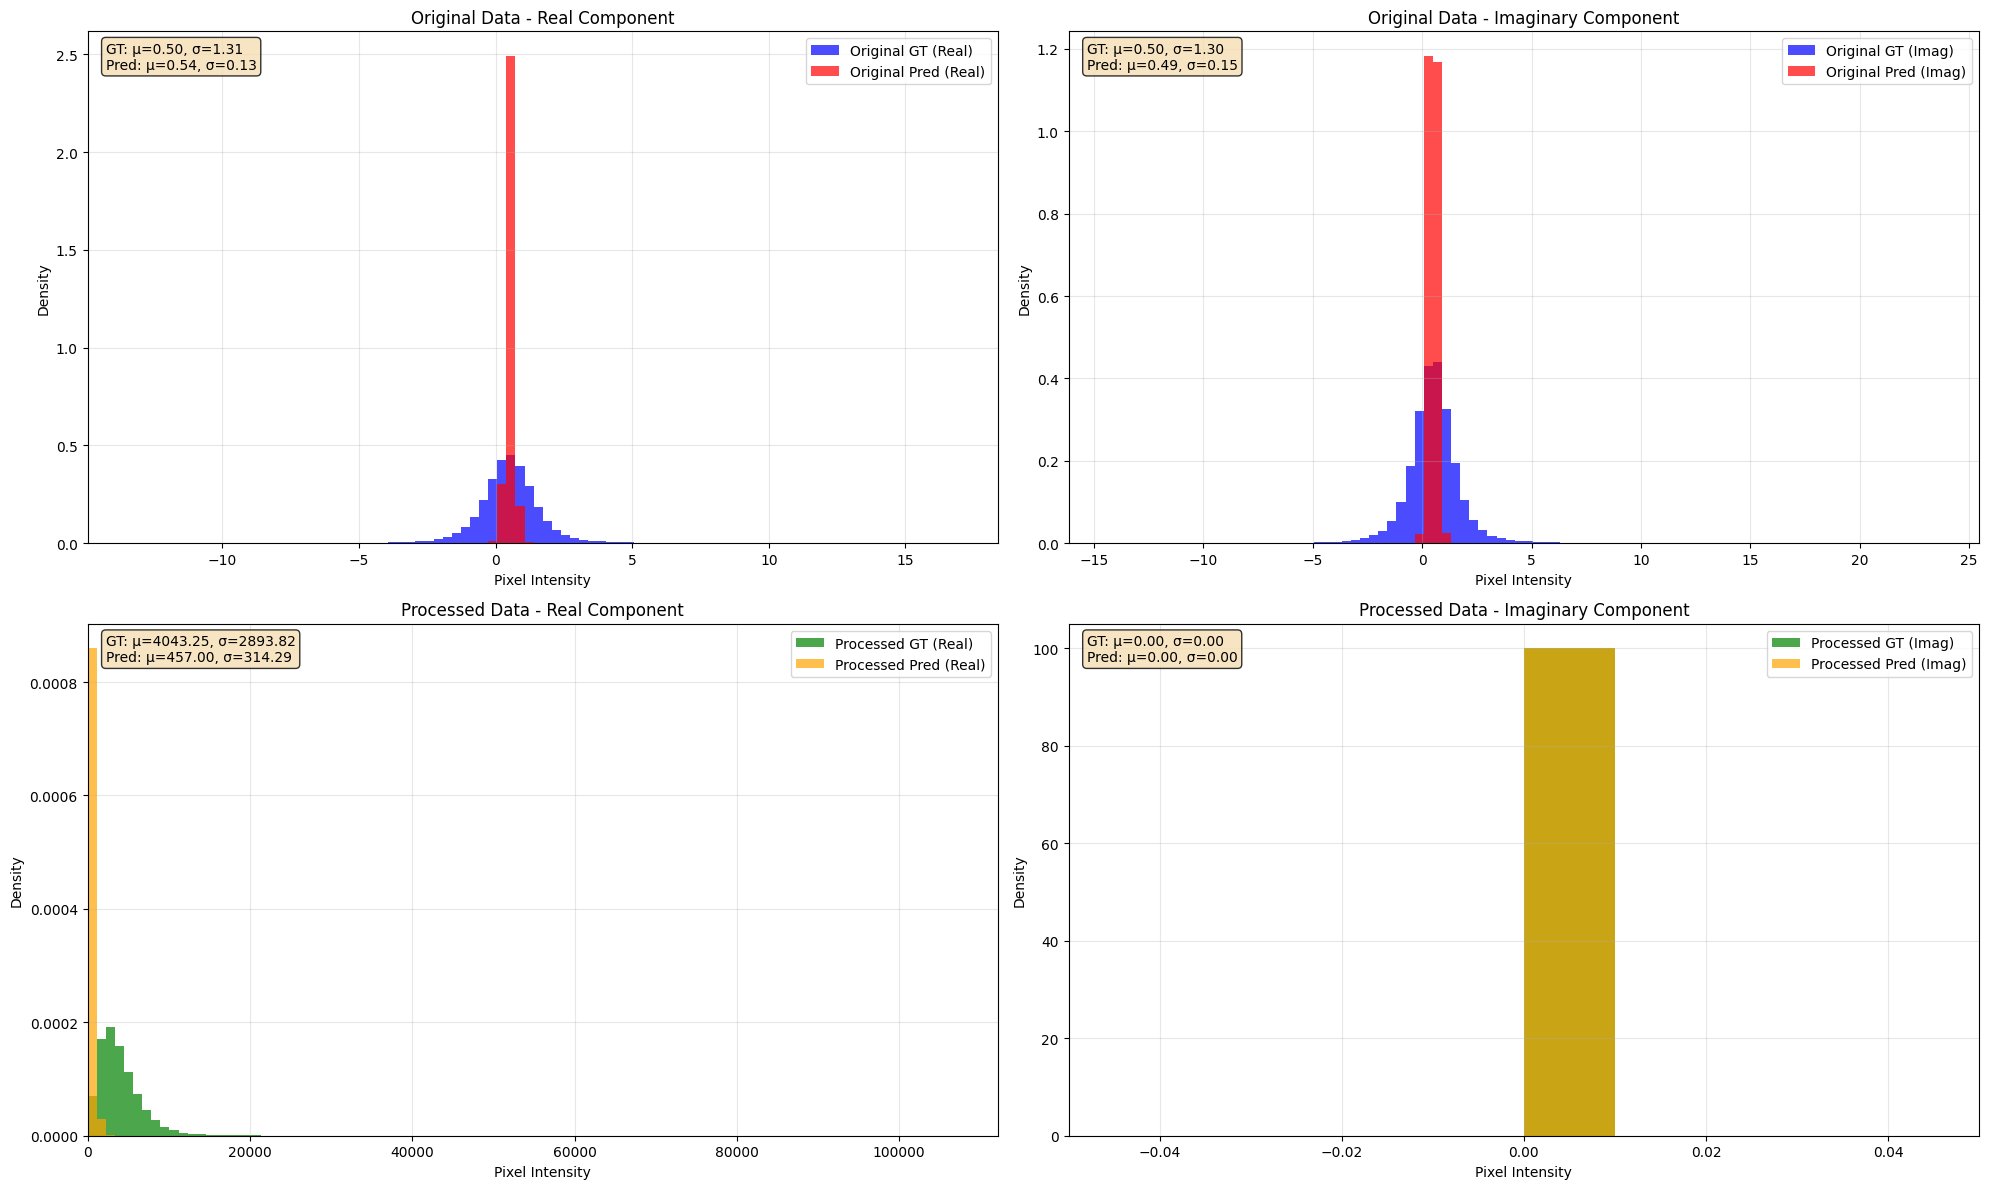


DETAILED STATISTICS

Original Data:
------------------------------

Real Component:
  GT    - Mean:   0.5009, Std:   1.3069, Min: -14.9365, Max:  18.3880
  Pred  - Mean:   0.5387, Std:   0.1325, Min:  -0.7217, Max:   1.3675
  Diff  - Mean:  -0.0378, Std:   1.3155

Imaginary Component:
  GT    - Mean:   0.5025, Std:   1.3016, Min: -16.1625, Max:  25.4633
  Pred  - Mean:   0.4884, Std:   0.1540, Min:  -0.4214, Max:   1.8607
  Diff  - Mean:   0.0141, Std:   1.3129

Processed Data:
------------------------------

Real Component:
  GT    - Mean: 4043.2480, Std: 2893.8245, Min:   0.0000, Max: 112170.3828
  Pred  - Mean: 457.0009, Std: 314.2931, Min:   0.0000, Max: 7399.9487
  Diff  - Mean: 3586.2471, Std: 2810.9604

Imaginary Component:
  GT    - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000
  Pred  - Mean:   0.0000, Std:   0.0000, Min:   0.0000, Max:   0.0000


2025-10-14 14:40:04,187 - INFO - Visualization completed successfully!
2025-10-14 14:40:04,188 - INFO - Check the visualizations in: ./visualizations


  Diff  - Mean:   0.0000, Std:   0.0000


In [4]:
for i in range(5):

    print(compute_metrics(gts[i], preds[i]))
    display_inference_results(
        input_data=inputs[i],
        gt_data=gts[i],
        pred_data=preds[i],
        figsize=(20, 6),
        vminmax="auto",  # Adjust this range based on your data, 
        show=True, 
        save=False
    )
    plot_intensity_histograms(orig_gts[i][..., 0], orig_preds[i], gts[i], preds[i], figsize=(20, 12), bins=100)
    logger.info("Visualization completed successfully!")
    logger.info(f"Check the visualizations in: {save_dir}")